In [24]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

from tqdm import tqdm

import jaxdem as jd

def make_grid_state(n_per_axis, dim):
    radius = 0.5
    spacing = 3 * radius
    mass = 1.0

    spacing = jnp.array([spacing for _ in range(dim)])

    state = jd.utils.gridState.grid_state(
        n_per_axis=[n_per_axis for _ in range(dim)],
        spacing=spacing,
        radius=radius,
        mass=mass,
        jitter=0.0,
    )

    box_size = jnp.max(state.pos, axis=0) + spacing

    return state, box_size

def make_system_for_state(state, box_size, e_int, dt, linear_integrator_type="", rotation_integrator_type=""):
    mats = [jd.Material.create("elastic", young=e_int, poisson=0.5, density=1.0)]
    matcher = jd.MaterialMatchmaker.create("harmonic")
    mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)

    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type=linear_integrator_type,
        rotation_integrator_type=rotation_integrator_type,
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=mat_table,
        domain_kw=dict(
            box_size=box_size,
        ),
    )
    return system

def make_clump_grid_state(n_per_axis, dim, NV):
    sphere_state, box_size = make_grid_state(n_per_axis, dim)
    ID = jnp.concatenate([np.ones(NV) * i for i in sphere_state.ID]).astype(sphere_state.ID.dtype)
    _, nv = jnp.unique(ID, return_counts=True)
    local_id = jnp.arange(ID.size) - jnp.concatenate((jnp.zeros(1), jnp.cumsum(nv))).astype(sphere_state.ID.dtype)[ID]
    orientation = 2 * np.pi * local_id / nv[ID]
    pos_c = sphere_state.pos.copy()[ID]

    rad = (sphere_state.rad / nv)[ID]
    mass = (sphere_state.mass / nv)[ID]
    if sphere_state.dim == 2:
        angles = jnp.column_stack((jnp.cos(orientation), jnp.sin(orientation)))
    else:
        angles = jnp.column_stack((jnp.cos(orientation), jnp.sin(orientation), jnp.zeros_like(orientation)))
    pos_p = (sphere_state.rad[ID] - rad)[:, None] * angles
    inertia = jax.ops.segment_sum(mass * jnp.linalg.norm(pos_p, axis=-1) ** 2, ID, num_segments=sphere_state.N)[ID]

    state = jd.State.create(
        pos=pos_c + pos_p,
        ID=ID
    )

    state.pos_p = pos_p
    state.pos_c = pos_c
    state.rad = rad
    state.mass = mass
    state.inertia = inertia[:, None]
    state.q.w *= 0.0

    return state, box_size

def assign_velocities(state, target_temperature, rotational=True):
    seed = np.random.randint(0, 1000000)
    key = jax.random.PRNGKey(seed)
    key_vel, key_angVel = jax.random.split(key, 2)
    cid, offsets = jnp.unique(state.ID, return_index=True)
    N_clumps = cid.size
    clump_vel = jax.random.normal(key_vel, (N_clumps, state.dim))
    clump_vel -= jnp.mean(clump_vel, axis=0)
    clump_angVel = jax.random.normal(key_angVel, (N_clumps, state.angVel.shape[-1])) * (rotational)
    dof = state.dim * state.N + state.angVel.shape[-1] * state.N * (rotational)
    clump_mass = state.mass[offsets]
    clump_inertia = state.inertia[offsets]
    ke = jnp.sum((0.5 * clump_mass * jnp.sum(clump_vel ** 2, axis=-1)) + 0.5 * jnp.sum(clump_inertia * clump_angVel ** 2, axis=-1))
    temperature = 2 * ke / dof
    scale = jnp.sqrt(target_temperature / temperature)
    clump_vel *= scale
    clump_angVel *= scale
    state.vel = clump_vel[state.ID]
    state.angVel = clump_angVel[state.ID]
    return state

In [25]:
dim = 2
target_temperature = 1e-2
e_int = 1.0
n_per_axis = 2

dt_min = 1e-3
dt_max = 1e-1
dts = np.logspace(np.log10(dt_min), np.log10(dt_max), 5)[::-1]

NV = 2

dt = 1e-2


In [19]:
state, box_size = make_clump_grid_state(n_per_axis, dim, NV)
system = make_system_for_state(state, box_size, e_int, dt, linear_integrator_type="verlet", rotation_integrator_type="rot2dverlet")
state = assign_velocities(state, target_temperature, rotational=True)
n_steps = int(100000 * dt_min / dt)
save_stride = 1
n_snapshots = n_steps // save_stride
final_state, final_system, (traj_state, traj_system) = jd.System.trajectory_rollout(
    state, system, n=n_snapshots, stride=save_stride
)

_, offsets = jnp.unique(state.ID, return_index=True)

In [26]:
pe = jnp.sum(
    jax.vmap(
        lambda st, sys:
        sys.collider.compute_potential_energy(st, sys))(traj_state, traj_system)[:, offsets],
    axis=-1
)
ke_t = 0.5 * jnp.sum((traj_state.mass * jnp.sum(traj_state.vel ** 2, axis=-1))[:, offsets], axis=-1)

w = traj_state.q.rotate_back(traj_state.q, traj_state.angVel)
# ke_r = jnp.sum(0.5 * jnp.vecdot(w, traj_state.inertia * w)[:, offsets], axis=-1)
ke_r = 0.5 * jnp.sum((traj_state.inertia * traj_state.angVel ** 2), axis=(1, 2))

In [27]:
traj_state.mass * jnp.sum(traj_state.vel ** 2, axis=-1)

Array([[0.0614945 , 0.0614945 , 0.04790105, ..., 0.07599021, 0.047298  ,
        0.047298  ],
       [0.0614945 , 0.0614945 , 0.04790105, ..., 0.07599021, 0.047298  ,
        0.047298  ],
       [0.0614945 , 0.0614945 , 0.04790105, ..., 0.07599021, 0.047298  ,
        0.047298  ],
       ...,
       [0.02165958, 0.02165958, 0.03823597, ..., 0.10175557, 0.00808673,
        0.00808673],
       [0.02165958, 0.02165958, 0.03823597, ..., 0.10175557, 0.00808673,
        0.00808673],
       [0.02165958, 0.02165958, 0.03823597, ..., 0.10175557, 0.00808673,
        0.00808673]], dtype=float64)

In [28]:
import matplotlib.pyplot as plt

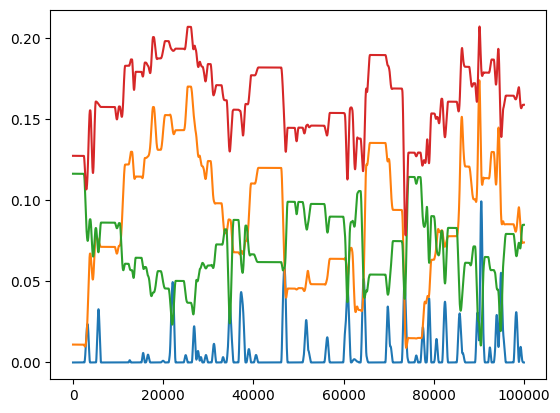

In [29]:
# plt.plot(ke_r + ke_t + pe)
plt.plot(pe)
plt.plot(ke_r)
plt.plot(ke_t)
plt.plot(pe * 0.5 + ke_t + ke_r)

In [31]:
w = state.q.rotate_back(state.q, state.angVel)
ke_r = 0.5 * jnp.vecdot(w, state.inertia * w)

In [19]:
import matplotlib.pyplot as plt

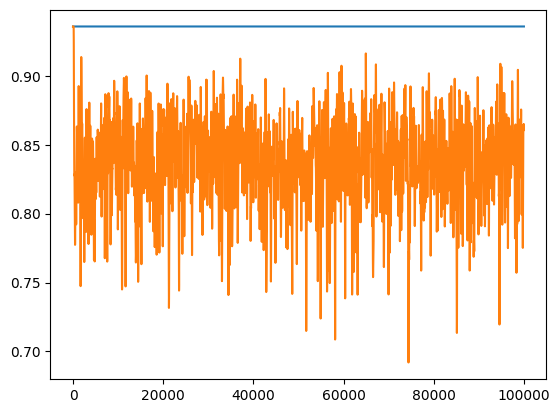

In [6]:
plt.plot(pe + ke)
# plt.plot(pe)
plt.plot(ke)

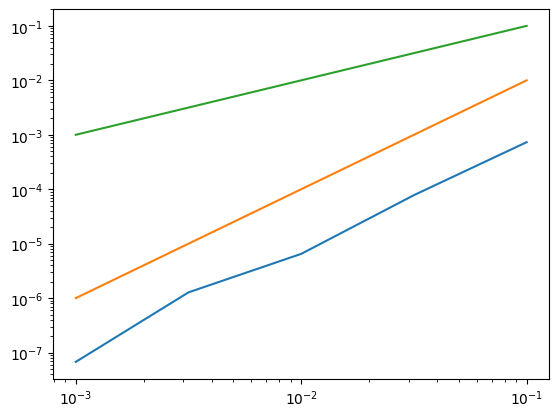

In [7]:
plt.plot(dts, fluctuation)
plt.plot(dts, dts ** 2)
plt.plot(dts, dts)
plt.xscale('log')
plt.yscale('log')

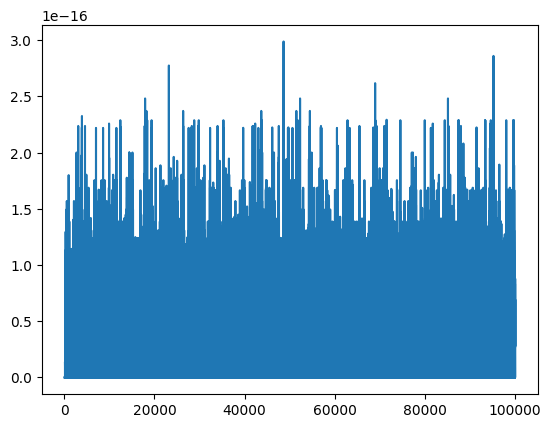

In [8]:
plt.plot(jnp.linalg.norm(jnp.sum(traj_state.force, axis=1), axis=-1))

In [84]:
jnp.sum(final_state.force, axis=0)

Array([ 2.9802322e-08, -2.2351742e-08], dtype=float32)

/home/mmccraw/anaconda3/envs/jaxdem/lib/python3.11/site-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/mmccraw/anaconda3/envs/jaxdem/lib/python3.11/site-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


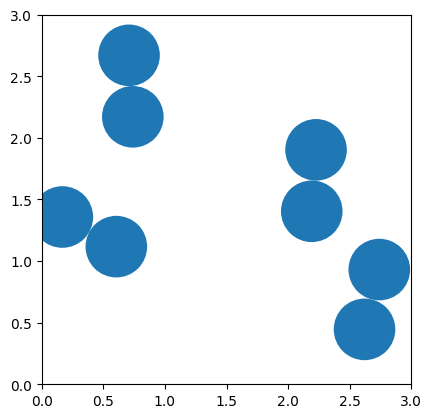

In [9]:
from matplotlib.patches import Circle
plt.gca().set_aspect('equal')
plt.xlim(0, final_system.domain.box_size[0])
plt.ylim(0, final_system.domain.box_size[1])
p = jnp.mod(final_state.pos, final_system.domain.box_size)
for pos, rad in zip(p, final_state.rad):
    plt.gca().add_artist(Circle(pos, rad))
plt.quiver(p[:, 0], p[:, 1], final_state.force[:, 0], final_state.force[:, 1])

In [73]:
jnp.linalg.norm(final_state.force, axis=-1)

Array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00917486,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00917486, 0.        , 0.        , 0.        , 0.     